## Textacy

Creating Topic Model with spaCy and Textacy 
1-  create a corpus of documents, transform them into a dtm, and then create a topic model.

adopted from textacy documentation.

In [22]:
import textacy
import spacy
nlp = spacy.load("en_core_web_sm")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [23]:
%pwd

'C:\\Users\\eali\\Documents\\NLP_practice\\NLP_Data\\gutenberg'

In [24]:
cd NLP_Data\gutenberg


[WinError 3] The system cannot find the path specified: 'NLP_Data\\gutenberg'
C:\Users\eali\Documents\NLP_practice\NLP_Data\gutenberg


## Load the contents as a corpus



In [25]:
## Here's our list of files.
import os
files = os.listdir('.')
files

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'README',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

## running each document through `spaCy`'s nlp model

In [ ]:
en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
records = []
labels = []
for text in files:
    try:
        textfile = textacy.io.read_text(text,lines=False)
        for t in textfile:
            doc = textacy.make_spacy_doc(t,lang=en)
            #print(doc._.preview)
            records.append(doc)
        labels.append(text)
    except Exception as err:
        print(err)
print()
print("All done.")

## Make the records into a corpus

In [58]:
corpus = textacy.Corpus(lang=en,data=records)

In [59]:
corpus

Corpus(15 docs, 1335684 tokens)

In [60]:
corpus[-1]._.preview

'Doc(60164 tokens: "[Stories to Tell to Children by Sara Cone Bryan...")'

## Some features of the corpus

In [62]:
corpus.n_docs, corpus.n_sents, corpus.n_tokens #apparently we didn't extract sentences here.

(15, 0, 1335684)

## Converting the corpus into a DTM or DFM

For now, this code is boilerplate from `textacy` to vectorize the corpus into a Document Term Matrix (a sparse matrix encoding of term frequencies).

In [42]:
import textacy.vsm
from textacy.vsm.vectorizers import Vectorizer
vectorizer = Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",
    min_df=2, max_df=0.95)
doc_term_matrix = vectorizer.fit_transform(
    (doc._.to_terms_list(ngrams=1, entities=True, as_strings=True) for doc in corpus))
print(repr(doc_term_matrix))

<15x11809 sparse matrix of type '<class 'numpy.float64'>'
	with 50827 stored elements in Compressed Sparse Row format>


## Making a topic model

Again, this is mostly boilerplate, using the DTM we created above to now create a topic model.

We can set the number of topics, and then see what the mixture of terms is for each "topic."

In [48]:
import textacy.tm  
from textacy.tm import TopicModel # note the importa
model = TopicModel("nmf", n_topics=5)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print("topic", topic_idx, ":", "   ".join(top_terms))

topic 0 : say   little   come   man   look   go   good   see   hear   Alice
topic 1 : haue   vs   Lord   thou   thee   thy   vpon   selfe   King   doe
topic 2 : Mr.   Emma   Mrs.   Miss   Jane   Churchill   Frank   good   determine   determined
topic 3 : Marianne   Mrs.   Edward   Lucy   sister   Mr.   Miss   Colonel   Middleton   John
topic 4 : copy   Small   distribute   file   receive   College   Illinois   royalty   3   2


## Which topics do the documents belong to? 

The topic mixture is ranked, so we can see from left to right which are the most likely topics.

In [64]:
for doc_idx, topics in model.top_doc_topics(doc_topic_matrix, docs=range(15), top_n=4):
    print(corpus[doc_idx]._.preview, ":", topics)

Doc(9364 tokens: "[Poems by William Blake 1789]    SONGS OF INNOC...") : (0, 1, 4, 3)
Doc(37036 tokens: "[Alice's Adventures in Wonderland by Lewis Carr...") : (0, 4, 3, 2)
Doc(165954 tokens: "[Leaves of Grass by Walt Whitman 1855]   Come, ...") : (0, 1, 4, 3)
Doc(107376 tokens: "[Paradise Lost by John Milton 1667]      Book I...") : (0, 1, 4, 3)
Doc(2077 tokens: "Project Gutenberg Selections http://gutenberg.n...") : (4, 3, 2, 1)
Doc(107576 tokens: "[Persuasion by Jane Austen 1818]   Chapter 1   ...") : (0, 4, 3, 2)
Doc(229450 tokens: "[The Parent's Assistant, by Maria Edgeworth]   ...") : (0, 2, 3, 4)
Doc(75404 tokens: "[The Man Who Was Thursday by G. K. Chesterton 1...") : (0, 4, 3, 2)
Doc(20052 tokens: "[The Adventures of Buster Bear by Thornton W. B...") : (0, 4, 3, 2)
Doc(206783 tokens: "[Emma by Jane Austen 1816]  VOLUME I  CHAPTER I...") : (2, 0, 4, 3)
Doc(94610 tokens: "[The Wisdom of Father Brown by G. K. Chesterton...") : (0, 4, 3, 2)
Doc(40271 tokens: "[The Tragedie of Haml

## Getting the topic weights

We can also retrieve the topic weights per document.

In [76]:
import pandas as pd
doc_topic_mix = pd.DataFrame(doc_topic_matrix)
doc_topic_mix.columns=["topic_"+ str(f) for f in range(5)]
doc_topic_mix.index = labels
doc_topic_mix

,topic_0,topic_1,topic_2,topic_3,topic_4
blake-poems.txt,0.365703,0.096265,0.000000,0.000000,0.000000
carroll-alice.txt,0.551634,0.000000,0.000000,0.000000,0.000000
whitman-leaves.txt,0.440786,0.063444,0.000000,0.000000,0.000000
milton-paradise.txt,0.295974,0.216024,0.000000,0.000000,0.000000
README,0.000000,0.000000,0.000000,0.000000,1.413921
austen-persuasion.txt,0.434008,0.000000,0.000000,0.000000,0.000000
edgeworth-parents.txt,0.754098,0.000000,0.180810,0.076310,0.000000
chesterton-thursday.txt,0.726810,0.000000,0.000000,0.000000,0.000000
burgess-busterbrown.txt,0.326869,0.000000,0.000000,0.000000,0.000000
austen-emma.txt,0.323668,0.000000,0.968896,0.000000,0.000000


In [79]:
doc_topic_mix.idxmax(axis=1)

blake-poems.txt            topic_0
carroll-alice.txt          topic_0
whitman-leaves.txt         topic_0
milton-paradise.txt        topic_0
README                     topic_4
austen-persuasion.txt      topic_0
edgeworth-parents.txt      topic_0
chesterton-thursday.txt    topic_0
burgess-busterbrown.txt    topic_0
austen-emma.txt            topic_2
chesterton-brown.txt       topic_0
shakespeare-hamlet.txt     topic_1
austen-sense.txt           topic_3
shakespeare-macbeth.txt    topic_1
bryant-stories.txt         topic_0
dtype: object

In [66]:
for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
    print(i, val)

0 0.5042434132515242
1 0.2033470321275639
2 0.0932765549186733
3 0.08442047245079606
4 0.1147125272514425


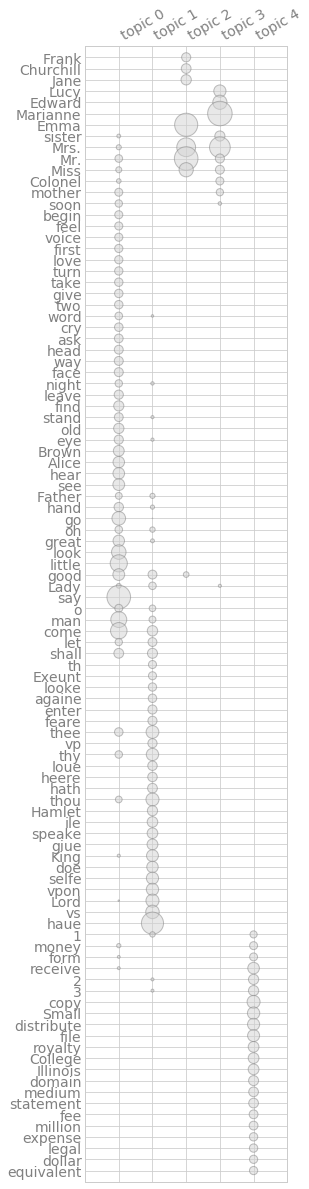

In [65]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term,topics=-1,  n_terms=100, sort_terms_by="seriation")